In [ ]:
pip install pandas

In [ ]:
pip install torch

In [ ]:
pip install transformers

In [ ]:
pip install matplotlib

In [ ]:
pip install datasets


In [ ]:
pip install sklearn

In [ ]:
pip install peft

In [ ]:
pip install watermark

In [ ]:
pip install evaluate

In [ ]:
pip install tensorflow_addons

In [1]:
from torch.utils.data import DataLoader
from transformers import AdamW
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import pandas as pd
import uuid
from datasets import Dataset
from transformers import DistilBertTokenizer, DistilBertForQuestionAnswering, DataCollatorWithPadding, TrainingArguments, Trainer,pipeline
from datasets import load_dataset, concatenate_datasets
from peft import PeftConfig, PeftModel


In [3]:


# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2

import os
import torch
import evaluate
import datasets
import collections
import transformers
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from time import perf_counter
from torch.utils.data import DataLoader
from datasets import (
    load_dataset,
    disable_progress_bar
)
from transformers import (
    pipeline,
    Trainer,
    TrainingArguments,
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    IntervalStrategy
)

device = "cuda" if torch.cuda.is_available() else "cpu"
cache_dir = None

%watermark -a 'Ethen' -d -u -iv

Author: Ethen

Last updated: 2023-11-22

numpy       : 1.26.2
evaluate    : 0.4.1
transformers: 4.35.2
torch       : 2.1.1
datasets    : 2.15.0
matplotlib  : 3.8.2
pandas      : 2.1.3



In [4]:
import torch
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
import transformers
from transformers import BertTokenizerFast, BertForQuestionAnswering
from peft import LoraConfig, get_peft_model
# from sklearn.metrics import f1_score
from tqdm import tqdm
import timeit

from squad_dataset import SquadDataset

In [5]:
dataset = load_dataset('squad')

In [6]:
import pandas as pd

df = pd.read_csv('./data/data.csv')

df.columns

Index(['context', 'question', 'answer', 'answer_start'], dtype='object')

In [7]:
column_names_qtn=["data"]
qtndata = []
qtndf=pd.DataFrame(qtndata, columns=column_names_qtn)
for index, row in df.iterrows():
  lst=[]
  qas=[{"question": row['question'], "id":str(uuid.uuid4().hex), "answers":[{"text":row['answer'] ,"answer_start": int(row['answer_start'])}]}]
  paragraphs=[{"context": row['context'], "qas": qas}]
  lst.append({"title":'introduction', "paragraphs":paragraphs})
qtndf.loc[len(qtndf.index)] = [lst]

In [8]:
qtndf.head()

,data
0,"[{'title': 'introduction', 'paragraphs': [{'co..."


In [9]:
qtndf.describe()

,data
count,1
unique,1
top,"[{'title': 'introduction', 'paragraphs': [{'co..."
freq,1


In [10]:
traindataset = Dataset.from_pandas(qtndf)

In [11]:
traindataset = traindataset.remove_columns(["__index_level_0__"])

In [12]:
traindataset[0]

{'data': [{'paragraphs': [{'context': 'this sow is entered in by vendor and customer on the sow effective date. the term of this sow shall begin on july 31st, 2001 (the in-service date) and shall continue for nine (9) months there after to march 1st, 2002 (the sow initial term). upon expiration of the initial term, this sow shall automatically renew for successive nine  (9) months (each a renewal term, and together with the initial term, the term) unless either party provides the other party with less than fourty one (41) days prior written notice of termination effective on the next scheduled expiration date of the term. customer shall give any notice of non-renewal by sending email to email id cancel@transunion.com. this sow shall automatically terminate upon any termination or expiration of the agreement. ',
     'qas': [{'answers': [{'answer_start': 658,
         'text': 'email id cancel@transunion.com'}],
       'id': 'a208feab275f4c058804f15319bb0307',
       'question': 'What is

In [13]:
dataset_from_hug = load_dataset('squad')

In [14]:
dataset_from_hug

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [15]:
dataset_from_hug['train'][:10]

{'id': ['5733be284776f41900661182',
  '5733be284776f4190066117f',
  '5733be284776f41900661180',
  '5733be284776f41900661181',
  '5733be284776f4190066117e',
  '5733bf84d058e614000b61be',
  '5733bf84d058e614000b61bf',
  '5733bf84d058e614000b61c0',
  '5733bf84d058e614000b61bd',
  '5733bf84d058e614000b61c1'],
 'title': ['University_of_Notre_Dame',
  'University_of_Notre_Dame',
  'University_of_Notre_Dame',
  'University_of_Notre_Dame',
  'University_of_Notre_Dame',
  'University_of_Notre_Dame',
  'University_of_Notre_Dame',
  'University_of_Notre_Dame',
  'University_of_Notre_Dame',
  'University_of_Notre_Dame'],
 'context': ['Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is

In [16]:
traindataset.to_json("./data/train.json")   

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1018

In [17]:
traindataset

Dataset({
    features: ['data'],
    num_rows: 1
})

In [18]:
import pandas as pd

dfv = pd.read_csv('./data/validation.csv')

dfv.columns

Index(['context', 'question', 'answer', 'answer_start'], dtype='object')

In [19]:
dataset = load_dataset('squad')

In [20]:
column_names_qtnv=["data"]
qtndatav = []
qtndfv=pd.DataFrame(qtndata, columns=column_names_qtn)
for index, row in dfv.iterrows():
  lst=[]
  qas=[{"question": row['question'], "id":str(uuid.uuid4().hex), "answers":[{"text":row['answer'] ,"answer_start": int(row['answer_start'])}]}]
  paragraphs=[{"context": row['context'], "qas": qas}]
  lst.append({"title":'introduction', "paragraphs":paragraphs})
qtndfv.loc[len(qtndfv.index)] = [lst]

In [21]:
qtndfv.shape

(1, 1)

In [22]:
validationdataset = Dataset.from_pandas(qtndfv)

In [23]:
validationdataset = validationdataset.remove_columns(["__index_level_0__"])

In [24]:
validationdataset.to_json("./data/valid.json")   

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

416

In [25]:
traindataset

Dataset({
    features: ['data'],
    num_rows: 1
})

In [26]:
validationdataset

Dataset({
    features: ['data'],
    num_rows: 1
})

In [27]:

transformers.utils.logging.set_verbosity_error()
device = "cuda" if torch.cuda.is_available() else "cpu"

LEARNING_RATE = 5e-5
BATCH_SIZE = 16
EPOCHS = 3
VALID_DATA_PATH = "./data/valid.json"
DATA_PATH = "./data/train.json"
MODEL_PATH = "bert-base-uncased"
MODEL_SAVE_PATH = f"./bert-qa/models/{MODEL_PATH}-lr{LEARNING_RATE}-epochs{EPOCHS}-batchsize{BATCH_SIZE}-LORA-retrain/"
LORA = True

tokenizer = BertTokenizerFast.from_pretrained(MODEL_PATH)
model = BertForQuestionAnswering.from_pretrained(MODEL_PATH).to(device)

if LORA:
    config = LoraConfig(
        task_type = "QUESTION_ANS",
        inference_mode = False,
        r = 16,
        lora_alpha = 32,
        lora_dropout = 0.05,
        fan_in_fan_out = False,
        bias = "none",
    )

    print("# Trainable Parameters Before LoRA")
    print(model.num_parameters())
    model = get_peft_model(model, config)
    print("# Trainable Parameters After LoRA") 
    model.print_trainable_parameters()

tdataset = SquadDataset(DATA_PATH, tokenizer)
vdataset = SquadDataset(VALID_DATA_PATH, tokenizer)

# Trainable Parameters Before LoRA
108893186
# Trainable Parameters After LoRA
trainable params: 591,362 || all params: 109,484,548 || trainable%: 0.5401328413942029


In [28]:

generator = torch.Generator().manual_seed(42)
train_dataset=tdataset
val_dataset=vdataset
test_dataset=vdataset

train_dataloader = DataLoader(dataset=train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

In [30]:
# Lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

100%|██████████| 1/1 [00:00<00:00, 25.92it/s]

100%|██████████| 1/1 [00:00<00:00, 73.25it/s]


------------------------------
Train Loss EPOCH 1: 21.1142
Valid Loss EPOCH 1: 4.5144
------------------------------
Epoch 1/3:
  Training Loss: 5.2378, Training Accuracy: 0.0000
  Validation Loss: 4.5144, Validation Accuracy: 0.0000



100%|██████████| 1/1 [00:00<00:00, 27.94it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 16.68it/s]

------------------------------
Train Loss EPOCH 2: 26.3689
Valid Loss EPOCH 2: 4.5120
------------------------------
Epoch 2/3:
  Training Loss: 5.2547, Training Accuracy: 0.0000
  Validation Loss: 4.5120, Validation Accuracy: 0.0000



100%|██████████| 1/1 [00:00<00:00, 28.99it/s]

100%|██████████| 3/3 [00:00<00:00, 16.86it/s]


------------------------------
Train Loss EPOCH 3: 31.6838
Valid Loss EPOCH 3: 4.5097
------------------------------
Epoch 3/3:
  Training Loss: 5.3150, Training Accuracy: 0.0000
  Validation Loss: 4.5097, Validation Accuracy: 0.0000
Training Time: 0.18s


100%|██████████| 1/1 [00:00<00:00, 72.02it/s]


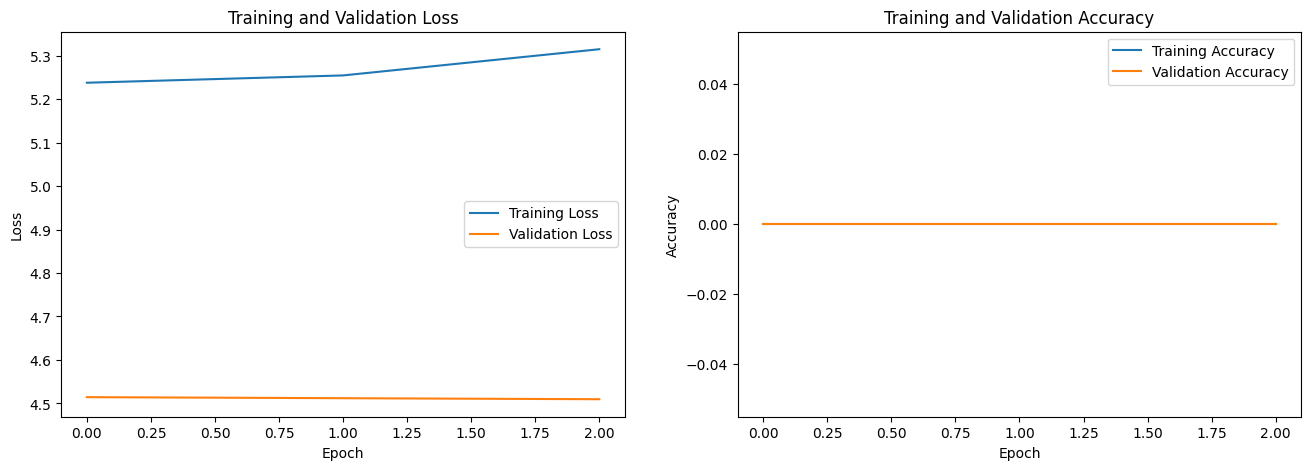

In [33]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

start = timeit.default_timer() 
for epoch in tqdm(range(EPOCHS)):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for idx, sample in enumerate(tqdm(train_dataloader)):
        input_ids = sample['input_ids'].to(device)
        attention_mask = sample['attention_mask'].to(device)
        start_positions = sample['start_positions'].to(device)
        end_positions = sample['end_positions'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        total_loss += loss.item()
    
    
    
        # Calculate accuracy
        start_preds = outputs.start_logits.argmax(dim=1)
        end_preds = outputs.end_logits.argmax(dim=1)
        correct_predictions += ((start_preds == start_positions) & (end_preds == end_positions)).sum().item()
        total_samples += len(start_positions)
       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()

    train_loss = train_running_loss / (idx + 1)
    epoch_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples

    model.eval()
    val_running_loss = 0
    val_total_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0
    with torch.no_grad():
        for idx, sample in enumerate(tqdm(val_dataloader)):
            input_ids = sample['input_ids'].to(device)
            attention_mask = sample['attention_mask'].to(device)
            start_positions = sample['start_positions'].to(device)
            end_positions = sample['end_positions'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            val_loss = outputs[0]
            val_total_loss += val_loss.item()

            # Calculate accuracy
            val_start_preds = outputs.start_logits.argmax(dim=1)
            val_end_preds = outputs.end_logits.argmax(dim=1)
            val_correct_predictions += ((val_start_preds == start_positions) & (val_end_preds == end_positions)).sum().item()
            val_total_samples += len(start_positions)
            
            val_running_loss += outputs.loss.item()
        val_loss = val_running_loss / (idx + 1)
    epoch_val_loss = val_total_loss / len(val_dataloader)
    val_accuracy = val_correct_predictions / val_total_samples

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print("-"*30)
    print(f'Epoch {epoch + 1}/{3}:')
    print(f'  Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')
    print(f'  Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')



    train_losses.append(epoch_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)
stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

torch.cuda.empty_cache()

model.eval()
preds = []
true = []
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader)):
        input_ids = sample['input_ids'].to(device)
        attention_mask = sample['attention_mask'].to(device)
        start_positions = sample['start_positions']
        end_positions = sample['end_positions']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        start_pred = torch.argmax(outputs['start_logits'], dim=1).cpu().detach()
        end_pred = torch.argmax(outputs['end_logits'], dim=1).cpu().detach()

        preds.extend([[int(i), int(j)] for i, j in zip(start_pred, end_pred)])
        true.extend([[int(i), int(j)] for i, j in zip(start_positions, end_positions)])

preds = [item for sublist in preds for item in sublist]
true = [item for sublist in true for item in sublist]


# Plot the learning curves
plt.figure(figsize=(16, 5))



plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
# f1_value = f1_score(true, preds, average="macro")
# print(f"F1 Score: {f1_value}")

In [35]:
def lora_infer(question, context, MODEL_PATH):
    config = PeftConfig.from_pretrained(MODEL_PATH)
    model = PeftModel.from_pretrained(BertForQuestionAnswering.from_pretrained(config.base_model_name_or_path), MODEL_PATH)
    tokenizer = BertTokenizerFast.from_pretrained(config.base_model_name_or_path)

    start = timeit.default_timer()
    qa_model = pipeline(task="question-answering", model=model, tokenizer=tokenizer)
    stop = timeit.default_timer()
    print(f"Inference Time: {stop-start:.2f}s")
    return(qa_model(question=question, context=context))

In [36]:
def vanilla_infer(question, context, MODEL_PATH):
    model = BertForQuestionAnswering.from_pretrained(MODEL_PATH)
    tokenizer = BertTokenizerFast.from_pretrained(MODEL_PATH)
    start = timeit.default_timer()
    qa_model = pipeline(task="question-answering", model=model, tokenizer=tokenizer)
    stop = timeit.default_timer()
    print(f"Inference Time: {stop-start:.2f}s")
    return(qa_model(question=question, context=context))

In [43]:
MODEL_PATH = "./models/qa-bert-base"
LORA = False

question = "who is vendor?"
context = "this statement of work (sow) is entered into as of november 30th, 2022 (the sow effective date), by and between unified com (customer), a corporation located at salesforce tower, 415 mission street, 3rd floar, seattle, ca 84105, and transunion information services, inc. (vendor), a middleeast corporation with offices at 1906 reston metrplaza, suite 500 reston, wa 201390. this sow is subject that certain master. service agreement entered in by and between the vendor and customer with an effective date of 11/30/2022,as amended (the master service agreement, or the msa, or the agreement.  "
if LORA:
    print(lora_infer(question, context, MODEL_PATH))
else:
    print(vanilla_infer(question, context, MODEL_PATH))

Inference Time: 0.00s
{'score': 0.18644268810749054, 'start': 112, 'end': 123, 'answer': 'unified com'}


In [45]:
MODEL_PATH = "./models/qa-bert-base"
LORA = True

question = "who is customer?"
context = "this statement of work (sow) is entered into as of november 30th, 2022 (the sow effective date), by and between unified com (customer), a corporation located at salesforce tower, 415 mission street, 3rd floar, seattle, ca 84105, and transunion information services, inc. (vendor), a middleeast corporation with offices at 1906 reston metrplaza, suite 500 reston, wa 201390. this sow is subject that certain master. service agreement entered in by and between the vendor and customer with an effective date of 11/30/2022,as amended (the master service agreement, or the msa, or the agreement.  "

if LORA:
    print(lora_infer(question, context, MODEL_PATH))
else:
    print(vanilla_infer(question, context, MODEL_PATH))

The model 'PeftModelForQuestionAnswering' is not supported for question-answering. Supported models are ['AlbertForQuestionAnswering', 'BartForQuestionAnswering', 'BertForQuestionAnswering', 'BigBirdForQuestionAnswering', 'BigBirdPegasusForQuestionAnswering', 'BloomForQuestionAnswering', 'CamembertForQuestionAnswering', 'CanineForQuestionAnswering', 'ConvBertForQuestionAnswering', 'Data2VecTextForQuestionAnswering', 'DebertaForQuestionAnswering', 'DebertaV2ForQuestionAnswering', 'DistilBertForQuestionAnswering', 'ElectraForQuestionAnswering', 'ErnieForQuestionAnswering', 'ErnieMForQuestionAnswering', 'FalconForQuestionAnswering', 'FlaubertForQuestionAnsweringSimple', 'FNetForQuestionAnswering', 'FunnelForQuestionAnswering', 'GPT2ForQuestionAnswering', 'GPTNeoForQuestionAnswering', 'GPTNeoXForQuestionAnswering', 'GPTJForQuestionAnswering', 'IBertForQuestionAnswering', 'LayoutLMv2ForQuestionAnswering', 'LayoutLMv3ForQuestionAnswering', 'LEDForQuestionAnswering', 'LiltForQuestionAnswering

Inference Time: 0.00s
{'score': 0.09022486209869385, 'start': 407, 'end': 413, 'answer': 'master'}


In [46]:
dataset = load_dataset('squad')

In [47]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [54]:
train_dataset=dataset['train'].select(range(5000))
val_dataset=dataset['validation'].select(range(500))
test_dataset=dataset['validation'].select(range(500))


In [60]:
for row in train_dataset.select(range(2)):
    print(row)

{'id': '5733be284776f41900661182', 'title': 'University_of_Notre_Dame', 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}
{'id': '5733be284776f4190066117f', 'title': 'Universit

In [56]:

train_dataloader = DataLoader(dataset=train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

In [57]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

start = timeit.default_timer() 
for epoch in tqdm(range(EPOCHS)):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for idx, sample in enumerate(tqdm(train_dataloader)):
        input_ids = sample['input_ids'].to(device)
        attention_mask = sample['attention_mask'].to(device)
        start_positions = sample['start_positions'].to(device)
        end_positions = sample['end_positions'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        total_loss += loss.item()
    
    
    
        # Calculate accuracy
        start_preds = outputs.start_logits.argmax(dim=1)
        end_preds = outputs.end_logits.argmax(dim=1)
        correct_predictions += ((start_preds == start_positions) & (end_preds == end_positions)).sum().item()
        total_samples += len(start_positions)
       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()

    train_loss = train_running_loss / (idx + 1)
    epoch_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples

    model.eval()
    val_running_loss = 0
    val_total_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0
    with torch.no_grad():
        for idx, sample in enumerate(tqdm(val_dataloader)):
            input_ids = sample['input_ids'].to(device)
            attention_mask = sample['attention_mask'].to(device)
            start_positions = sample['start_positions'].to(device)
            end_positions = sample['end_positions'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            val_loss = outputs[0]
            val_total_loss += val_loss.item()

            # Calculate accuracy
            val_start_preds = outputs.start_logits.argmax(dim=1)
            val_end_preds = outputs.end_logits.argmax(dim=1)
            val_correct_predictions += ((val_start_preds == start_positions) & (val_end_preds == end_positions)).sum().item()
            val_total_samples += len(start_positions)
            
            val_running_loss += outputs.loss.item()
        val_loss = val_running_loss / (idx + 1)
    epoch_val_loss = val_total_loss / len(val_dataloader)
    val_accuracy = val_correct_predictions / val_total_samples

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print("-"*30)
    print(f'Epoch {epoch + 1}/{3}:')
    print(f'  Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')
    print(f'  Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')



    train_losses.append(epoch_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)
stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

torch.cuda.empty_cache()

model.eval()
preds = []
true = []
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader)):
        input_ids = sample['input_ids'].to(device)
        attention_mask = sample['attention_mask'].to(device)
        start_positions = sample['start_positions']
        end_positions = sample['end_positions']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        start_pred = torch.argmax(outputs['start_logits'], dim=1).cpu().detach()
        end_pred = torch.argmax(outputs['end_logits'], dim=1).cpu().detach()

        preds.extend([[int(i), int(j)] for i, j in zip(start_pred, end_pred)])
        true.extend([[int(i), int(j)] for i, j in zip(start_positions, end_positions)])

preds = [item for sublist in preds for item in sublist]
true = [item for sublist in true for item in sublist]


# Plot the learning curves
plt.figure(figsize=(16, 5))



plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
# f1_value = f1_score(true, preds, average="macro")
# print(f"F1 Score: {f1_value}")

  0%|          | 0/3 [00:00<?, ?it/s]


KeyError: 'input_ids'

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForQuestionAnswering
import torch

config = PeftConfig.from_pretrained(MODEL_PATH)
model = PeftModel.from_pretrained(BertForQuestionAnswering.from_pretrained(config.base_model_name_or_path), MODEL_PATH)
tokenizer = BertTokenizerFast.from_pretrained(config.base_model_name_or_path)
question = ""
context = ""
# tokenizer = DistilBertTokenizer.from_pretrained(
#     'distilbert-base-uncased-distilled-squad')
# model = DistilBertForQuestionAnswering.from_pretrained(
#     'distilbert-base-uncased-distilled-squad')
input_ids = torch.tensor(tokenizer.encode(
    question,context, max_length=256, add_special_tokens=True)).unsqueeze(0)  # Batch size 1
start_positions = torch.tensor([1])
end_positions = torch.tensor([3])

outputs = model(input_ids, start_positions=start_positions,
                end_positions=end_positions)
loss, start_scores, end_scores = outputs[:3]

all_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
answer = tokenizer.convert_tokens_to_string(
    all_tokens[torch.argmax(start_scores): torch.argmax(end_scores) + 1])
print('*************')
print(answer)

In [ ]:
from transformers import pipeline
question_answererold = pipeline("question-answering", model='distilbert-base-cased-distilled-squad')


In [ ]:
question = ""
context = ""
result = question_answererold(question=question, context=context)


In [ ]:
result

In [ ]:

import nltk
from nltk.tokenize import word_tokenize
 
# Example domain-specific data
domain_data = [
    "The company plans to launch a new product next month.",
    "Our team successfully completed the project ahead of schedule.",
    "Customers are excited about the upcoming sale."
]
 
# Function to generate variations while maintaining POS tags
def generate_synthetic_data(sentences):
    synthetic_data = []
    for sentence in sentences:
        words = word_tokenize(sentence)
        pos_tags = nltk.pos_tag(words)  # Tag the domain-specific sentence
        
        # Generate variations while preserving POS tags (e.g., word substitutions, word order changes)
        # Modify the sentence here while ensuring POS tag coherence
        
        # Append modified sentence with its POS tags to synthetic data
        synthetic_data.append(pos_tags)
    
    return synthetic_data
 
# Generating synthetic data based on domain-specific data
synthetic_data = generate_synthetic_data(domain_data)
 
# Display the synthetic data with POS tags
for tagged_sentence in synthetic_data:
    print(tagged_sentence)

In [ ]:
pip install nltk


In [ ]:
nltk.download('punkt')

In [ ]:
nltk.download('averaged_perceptron_tagger')

In [61]:
import torch
from transformers import(
  AutoModelForQuestionAnswering,
  AutoTokenizer,
  pipeline
)
model_name = "sjrhuschlee/flan-t5-large-squad2"

# a) Using pipelines
nlp = pipeline(
  'question-answering',
  model=model_name,
  tokenizer=model_name,
  # trust_remote_code=True, # Do not use if version transformers>=4.31.0
)
qa_input = {
'question': f'{nlp.tokenizer.cls_token}who is customer?',  # '<cls>Where do I live?'
'context': 'this statement of work (sow) is entered into as of october 11th, 2021 (the sow effective date), by and between abc com (customer), a corporation located at abc tower, 514 st global street, 1rd floor, seattle, ca 78192, and transunion information services, inc. (vendor), a middleeast corporation with offices at 1906 reston metrplaza, suite 500 reston, wa 18903. this sow is subject that certain master. service agreement entered in by and between the vendor and customer with an effective date of 10/11/2021,as amended (the master service agreement, or the msa, or the agreement.'
}
res = nlp(qa_input)
# {'score': 0.984, 'start': 30, 'end': 37, 'answer': ' London'}

# b) Load model & tokenizer
model = AutoModelForQuestionAnswering.from_pretrained(
  model_name,
  # trust_remote_code=True # Do not use if version transformers>=4.31.0
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

question = f'{tokenizer.cls_token}what is effective date?'  # '<cls>Where do I live?'
context = 'this statement of work (sow) is entered into as of december 30th, 2022 (the sow effective date), by and between salesforce com (customer), a corporation located at salesforce tower, 415 mission street, 3rd floar,san francisco, ca 84105, and neustar information services, inc. (vendor), a delaware corporation with offices at 1906 reston metrplaza, suite 500 reston, wa 201390. this sowy is subject tthat certain master. service agreement entered in by and between the vendor and customer with an effective date of 06/30/2016,as amended (the master service agreement, or the msa, or the agreement.'
encoding = tokenizer(question, context, return_tensors="pt")
output = model(
  encoding["input_ids"],
  attention_mask=encoding["attention_mask"]
)

all_tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"][0].tolist())
answer_tokens = all_tokens[torch.argmax(output["start_logits"]):torch.argmax(output["end_logits"]) + 1]
answer = tokenizer.decode(tokenizer.convert_tokens_to_ids(answer_tokens))
# 'London'


config.json:   0%|          | 0.00/885 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/403 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.23k [00:00<?, ?B/s]

adapter_model.bin:   0%|          | 0.00/36.9M [00:00<?, ?B/s]

In [62]:
answer

'december 30th, 2022'

In [ ]:
output

In [ ]:
!nvidia-smi

In [ ]:
nvidia-smi